In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.feather as feather
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations
from sklearn.inspection import permutation_importance
from scipy.stats import f_oneway
from collections import defaultdict

Prepared Data for Robustness Checks from random sample of banks + the 3 pre-designated banks

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Path to your Feather file
file_path_df = 'df_temp.feather'
file_path_samples = 'df_samples.feather'

# Read the Feather files into DataFrames
df = pd.DataFrame(feather.read_feather(file_path_df))
df_samples = pd.DataFrame(feather.read_feather(file_path_samples))

df_samples['category'] = 'intermediate'
df_samples



,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,category
0,BANK OF AMERICA CORP,2000-03-31,2000,1,-0.286869,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.291793,-0.019791,-0.260042,-0.252144,-0.207346,intermediate
1,CB&T BANCSHARES INC,2000-03-31,2000,1,-0.353334,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379424,-0.136866,-0.337909,-0.298220,-0.297843,intermediate
2,CSB BANCSHARES AMENDED ESOP,2000-03-31,2000,1,-0.353338,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379428,-0.136870,-0.337913,-0.298270,-0.297849,intermediate
3,PRISM GROUP INC,2000-03-31,2000,1,-0.353339,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379429,-0.136870,-0.337914,-0.298280,-0.297847,intermediate
4,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,-0.352858,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379017,-0.136129,-0.337791,-0.278721,-0.297775,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,CSB BANCSHARES AMENDED ESOP,2023-12-31,2023,4,-0.353324,0.215012,0.265523,-0.135487,0.541890,0.230637,0.266428,NaN,0.291606,0.367903,-0.163138,0.032267,-0.020428,0.434643,-0.046070,0.053679,0.201053,0.195843,-0.052962,-0.176609,NaN,-0.053453,0.391050,0.257734,0.321299,NaN,0.176549,-0.002959,-0.379413,-0.136856,-0.337906,-0.298281,-0.297842,intermediate
686,PENN CMTY MUTUAL HOLDINGS INC,2023-12-31,2023,4,-0.353148,0.215012,0.265523,-0.135487,0.541890,0.230637,0.266428,NaN,0.291606,0.367903,-0.163138,0.032267,-0.020428,0.434643,-0.046070,0.053679,0.201053,0.195843,-0.052962,-0.176609,NaN,-0.053453,0.391050,0.257734,0.321299,NaN,0.176549,-0.002959,-0.379224,-0.136680,-0.337779,-0.298110,-0.297757,intermediate
687,PRISM GROUP INC,2023-12-31,2023,4,-0.353333,0.215012,0.265523,-0.135487,0.541890,0.230637,0.266428,NaN,0.291606,0.367903,-0.163138,0.032267,-0.020428,0.434643,-0.046070,0.053679,0.201053,0.195843,-0.052962,-0.176609,NaN,-0.053453,0.391050,0.257734,0.321299,NaN,0.176549,-0.002959,-0.379424,-0.136870,-0.337912,-0.298278,-0.297844,int

Though there was very little difference between the models, ultimately Random Forest Regression was found to be the best model. Using previously preprocessed data from before we will test the robustness of the model against the banks we previously set aside. 

Run each specific bank through the model.

In [3]:
df = df.loc[:, ['category'
                        , 'date'
                        , 'year'
                        , 'quarter'
                        , 'total_deposits'
                        , 'cpi'
                        , 'fed_fund_rate'
                        , 'housing_starts'
                        , 'personal_savings_rate'
                        , 'umich_consumer_sentiment_index']]
df

df_samples = df_samples.loc[:, ['name'
                        , 'category'
                        , 'date'
                        , 'year'
                        , 'quarter'
                        , 'total_deposits'
                        , 'cpi'
                        , 'fed_fund_rate'
                        , 'housing_starts'
                        , 'personal_savings_rate'
                        , 'umich_consumer_sentiment_index']]
df_samples

,name,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
0,BANK OF AMERICA CORP,intermediate,2000-03-31,2000,1,-0.286869,-0.185839,0.560238,0.146654,-0.040462,0.253748
1,CB&T BANCSHARES INC,intermediate,2000-03-31,2000,1,-0.353334,-0.185839,0.560238,0.146654,-0.040462,0.253748
2,CSB BANCSHARES AMENDED ESOP,intermediate,2000-03-31,2000,1,-0.353338,-0.185839,0.560238,0.146654,-0.040462,0.253748
3,PRISM GROUP INC,intermediate,2000-03-31,2000,1,-0.353339,-0.185839,0.560238,0.146654,-0.040462,0.253748
4,TORONTO-DOMINION BANK THE,intermediate,2000-03-31,2000,1,-0.352858,-0.185839,0.560238,0.146654,-0.040462,0.253748
...,...,...,...,...,...,...,...,...,...,...,...
685,CSB BANCSHARES AMENDED ESOP,intermediate,2023-12-31,2023,4,-0.353324,0.265523,0.541890,0.032267,-0.052962,-0.176609
686,PENN CMTY MUTUAL HOLDINGS INC,intermediate,2023-12-31,2023,4,-0.353148,0.265523,0.541890,0.032267,-0.052962,-0.176609
687,PRISM GROUP INC,intermediate,2023-12-31,2023,4,-0.353333,0.265523,0.541890,0.032267,-0.052962,-0.176609
688,TORONTO-DOMINION BANK THE,intermediate,2023-12-31,2023,4,-0.323270,0.265523,0.541890,0.032267,-0.052962,-0.176609


In [4]:
# Group by category and apply the shift function to each group
lagged_df = df.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))
lagged_df_samples = df_samples.groupby('name').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))

# Drop NaN values
lagged_df = lagged_df.dropna().reset_index(drop=True)
lagged_df_samples = lagged_df_samples.dropna().reset_index(drop=True)

C:\Users\eugen\AppData\Local\Temp\ipykernel_15448\2892517660.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lagged_df = df.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))
C:\Users\eugen\AppData\Local\Temp\ipykernel_15448\2892517660.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lagged_df_samples = df_samples.groupby('name').apply(lambda x: x.assign(t

In [5]:
selected_features=['cpi','fed_fund_rate','housing_starts','personal_savings_rate','umich_consumer_sentiment_index']

Consider Testing on Multiple Models for Robustness - each model is similar 

In [6]:
def run_random_forest(lagged_df, selected_features):
    """
    Run Random Forest regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20]
        }
        grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'rmse': rmse, 'r2': r2}
    
    return best_models

best_models_random_forest = run_random_forest(lagged_df, selected_features)
best_models_random_forest

c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'model': RandomForestRegressor(n_estimators=150, random_state=42),
  'rmse': 0.007222641877382201,
  'r2': 0.9959125261860037},
 'large': {'model': RandomForestRegressor(max_depth=10, random_state=42),
  'rmse': 0.009793732652013842,
  'r2': 0.9984769032933488},
 'small': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.023447445824509364,
  'r2': 0.9882410777719975}}

In [7]:
# Robustness Test on Random Forest Model
random_forest={}

test_X = lagged_df_samples[selected_features]
test_y = lagged_df_samples['total_deposits']

for category, info in best_models_random_forest.items():
    model = info['model']
    print(info)
    
    # Filter test_X and test_y by category
    test_X = lagged_df_samples[lagged_df_samples['category'] == category][selected_features]
    test_y = lagged_df_samples[lagged_df_samples['category'] == category]['total_deposits']
    
    # Make predictions only if there is data for the category
    if not test_X.empty:
        predictions = model.predict(test_X)
    
        rmse = mean_squared_error(test_y, predictions, squared=False)
        r2 = r2_score(test_y, predictions)       


    random_forest[category] = { 'rmse': rmse, 'r2': r2}

random_forest


{'model': RandomForestRegressor(n_estimators=150, random_state=42), 'rmse': 0.007222641877382201, 'r2': 0.9959125261860037}
{'model': RandomForestRegressor(max_depth=10, random_state=42), 'rmse': 0.009793732652013842, 'r2': 0.9984769032933488}
{'model': RandomForestRegressor(n_estimators=50, random_state=42), 'rmse': 0.023447445824509364, 'r2': 0.9882410777719975}


c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'intermediate': {'rmse': 0.23555406867561673, 'r2': -7.98485158121712},
 'large': {'rmse': 0.23555406867561673, 'r2': -7.98485158121712},
 'small': {'rmse': 0.23555406867561673, 'r2': -7.98485158121712}}

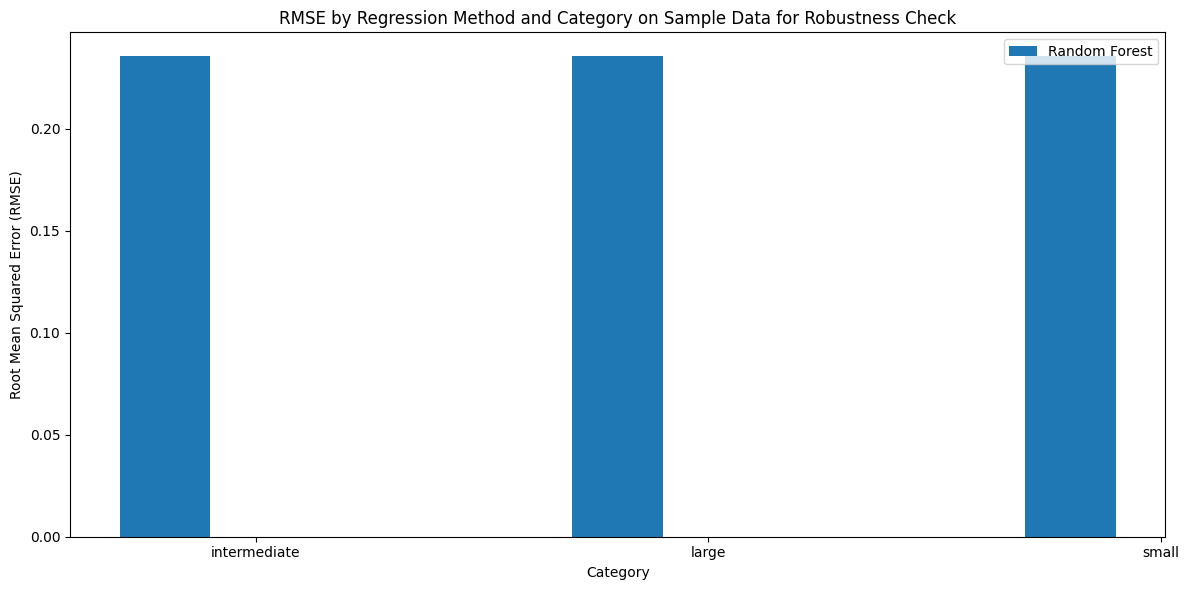

In [8]:
categories = lagged_df['category'].unique()

rmse_values = {
    #'Lasso': [lasso[cat]['rmse'] for cat in categories],
  #  'Ridge': [ridge[cat]['rmse'] for cat in categories],
    'Random Forest': [random_forest[cat]['rmse'] for cat in categories],
  #  'Gradient Boosting': [gradient_boosting[cat]['rmse'] for cat in categories]
}

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(categories))

for i, (method, rmse) in enumerate(rmse_values.items()):
    ax.bar([x + i * bar_width for x in index], rmse, bar_width, label=method)

ax.set_xlabel('Category')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_title('RMSE by Regression Method and Category on Sample Data for Robustness Check')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

Conclusion: Written once we figure out results. 

Sensitivity Analysis - Done on Random Forest Regression 

Parameters adjusted will be n_estimators and/or max_depth

In [9]:
X = df[selected_features]
y = df['total_deposits'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
n_estimators_range = [10, 50, 100, 150, 200]
max_depth_range = [None, 10, 20, 30]

results = []

for n_estimators in n_estimators_range:

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=10, random_state=42)  # Keeping max_depth constant
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    results.append({'n_estimators': n_estimators, 'max_depth': 10, 'RMSE': rmse, 'R2': r2})

# Repeat for max_depth variation
for max_depth in max_depth_range:
    model = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)  # Keeping n_estimators constant
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    results.append({'n_estimators': 100, 'max_depth': max_depth, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results)


c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\eugen\Documents\GitHub\deposit_size_prediction\env\Lib\site-packages\sklearn\metrics\_regression.

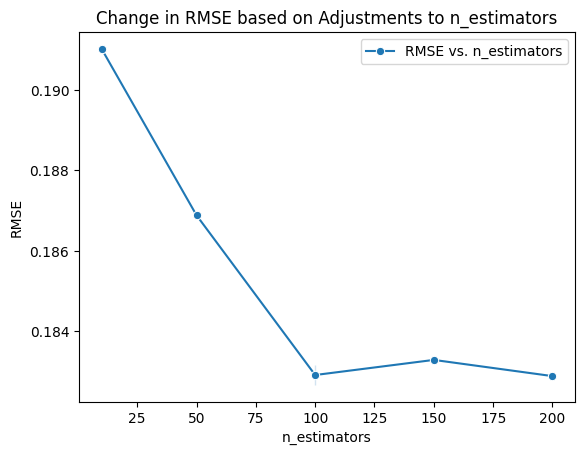

In [11]:
sns.lineplot(data=results_df, x='n_estimators', y='RMSE', marker='o', label='RMSE vs. n_estimators')
plt.title("Change in RMSE based on Adjustments to n_estimators")
plt.legend()
plt.show()

More trees (n_estimators) beneficial up to ~100 where no longer benefical, with little to no improvement. 

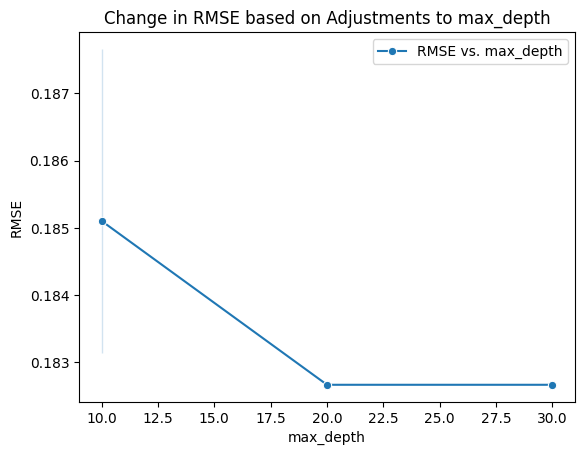

In [12]:
sns.lineplot(data=results_df, x='max_depth', y='RMSE', marker='o', label='RMSE vs. max_depth')
plt.title("Change in RMSE based on Adjustments to max_depth")
plt.legend()
plt.show()

No longer sensitive to changes once max_depth > 20